---
highlight-style:
  light: arrow.theme
  dark: arrow-dark.theme
format:
  html:
    code-line-numbers: false
    code-overflow: wrap
---

# Integer Programming {#sec-integer}

Integer programming has a wide range of applications across various industries and domains. Some of the classical applications of integer programming include:

- Production Planning and Scheduling: Integer programming is widely used in production planning and scheduling to optimize the allocation of resources, such as machines, workers, and raw materials. It helps to minimize costs and maximize efficiency by determining the optimal production schedule.

- Network Optimization: Integer programming is used in network optimization problems such as routing, scheduling, and allocation of resources in transportation networks, telecommunication networks, and supply chain management.

- Facility Location: Integer programming is used in facility location problems, which involve determining the optimal location for a facility based on various factors such as demand, supply, and transportation costs. It is commonly used in logistics, transportation, and distribution industries.

- Portfolio Optimization: Integer programming is used in finance to optimize investment portfolios, where the goal is to maximize the returns on the investment while minimizing risk.

- Cutting Stock and Bin Packing: Integer programming is used in cutting stock and bin packing problems where items of varying sizes must be packed into containers or cut from a stock. This is commonly used in the packaging and manufacturing industries.

- Crew Scheduling: Integer programming is used in crew scheduling problems, where the goal is to optimize the allocation of crew members to different shifts, duties, or activities. It is commonly used in industries such as airlines, railways, and public transportation.

- Timetabling: Integer programming is used in timetabling problems such as scheduling classes, exams, and events in academic institutions. It helps to minimize scheduling conflicts and maximize resource utilization.

This chapter explores the various methods that Google OR-Tools provides for modeling and solving (mixed) integer linear programming problems. The first step is to review the additional conditions that arise when modeling integer variables and solving integer programs. Following that, we use specific instances to demonstrate how these techniques are applied.

## Modeling Capabilities



When modeling integer programs, there are two main tasks that require attention. The first is declaring integer variables, and the second is selecting a solver that is capable of solving integer programs.

### Declaring Integer Variables

As reviewed in @sec-linear, Google OR-Tools provides two options to create integer variables:

+ The `Var(lb, ub, integer: bool, name)` function
+ The `IntVar(lb, ub, name)` function
+ The `Variable.SetInteger(integer: bool)` function

In the code snippet below, we create three integer variables using all the aforementioned approaches:

In [13]:
from ortools.linear_solver import pywraplp

solver = pywraplp.Solver.CreateSolver('SCIP')

# option 1
x = solver.Var(lb=0, ub=10, integer=True, name='x')

# option 2
y = solver.IntVar(lb=10, ub=20, name='y')

# option 3
z = solver.NumVar(lb=0, ub=5.5, name='z')
z.SetInteger(integer=True)

We can verify the types of variables $x, y, z$:

In [14]:
print(f"x is integer? {x.integer()}")
print(f"y is integer? {y.integer()}")
print(f"z is integer? {z.integer()}")

x is integer? True
y is integer? True
z is integer? True


### Selecting an Integer Solver

There are several solvers available for solving integer programs, and some options include:

- CBC_MIXED_INTEGER_PROGRAMMING or CBC
- BOP_INTEGER_PROGRAMMING or BOP
- SAT_INTEGER_PROGRAMMING or SAT or CP_SAT
- SCIP_MIXED_INTEGER_PROGRAMMING or SCIP
- GUROBI_MIXED_INTEGER_PROGRAMMING or GUROBI or GUROBI_MIP
- CPLEX_MIXED_INTEGER_PROGRAMMING or CPLEX or CPLEX_MIP
- XPRESS_MIXED_INTEGER_PROGRAMMING or XPRESS or XPRESS_MIP
- GLPK_MIXED_INTEGER_PROGRAMMING or GLPK or GLPK_MIP

It's important to note that some of these solvers are open-source, while others require a commercial license.
The code block above demonstrates how to create an instance of an integer solver. To do so, we simply need to specify the name of the solver in the Solver.CreateSolver() function.

In [15]:
solver = pywraplp.Solver.CreateSolver('CBC')

## Applications

In this section, we use Google OR-Tools to solve some of the classical integer programming problems.

### Job Shop Scheduling Problem

In the job shop scheduling problem (JSSP), there are a set of $n$ jobs $\mathcal{J}$ and a set of $m$ machines $\mathcal{M}$, and each job $j \in \mathcal{J}$ has a list of operations, given by $(o_1^j, \cdots, o_h^j, \cdots, o_m^j)$, that must be carried on the machines.
The order of operations in the list also indicates the processing order of the job, and $o_h^j$ represents the $h$-th operation of the job $j$.
In addition, the processing time of job $j$ on machine $i$, denoted by $p_{ij}$, is known in advance and is a non-negative integer.
At any moment of time, each machine can only process at most one job and no preemption is allowed which means that a job must completes its processing on a machine once it starts on that machine.
The objective is to find a processing schedule of the jobs on the machines such that the makespan, the completion time of the last operation of any job, is minimized.


To test the modeling of JSSP, we use a benchmarking instance from the OR-Library (@or-library), shown in the box below.
The two numbers in the first line represent the number of jobs and the number of machines, respectively.
Each remaining line contains the operations, processing machine and processing time, for each job.
Note that the machines are numbered starting from 0.

In [95]:
#| code-block-bg: true
#| code-block-border-left: "#31BAE9"

# Instance ft06 from OR-Library
# 6	6	
# 2	1	0	3	1	6	3	7	5	3	4	6
# 1	8	2	5	4	10	5	10	0	10	3	4
# 2	5	3	4	5	8	0	9	1	1	4	7
# 1	5	0	5	2	5	3	3	4	8	5	9
# 2	9	1	3	4	5	5	4	0	3	3	1
# 1	3	3	3	5	9	0	10	4	4	2	1

Suppose this instance data is saved in a file named *ft06.txt* and the code below defines an utility function to read and parse the instance for later use.

In [20]:
def read_jssp_instance(filename: str):
    with open(filename) as f:
        num_jobs, num_machines = [int(x) for x in next(f).split()]
        operations = []
        processing_times = {}
        job_idx = 0
        for line in f:
            info = [int(x) for x in line.split()]
            arr = [info[2 * m] for m in range(num_machines)]
            times = {info[2 * m]: info[2 * m + 1]
                    for m in range(num_machines)}
            operations.append(arr)
            processing_times[job_idx] = times
            job_idx += 1
    return num_jobs, num_machines, operations, processing_times

We present here three classical formulations of the JSSP from the literature and implement them using Google OR-Tools.

1. Disjunctive model

This model is taken from @ku_mixed_2016 and @manne_job-shop_1960. 
The decision variables are defined as follows:

- $x_{ij}$: the processing starting time of job $j$ on machine $i$
- $z_{ijk}$: a binary variable that equals 1 if job $j$ precedes job $k$ on machine $i$

The disjunctive model can then be stated as below.

\begin{align}
    \text{min.} &\quad C_{max} \label{jsp-dis-obj}\\
    \text{s.t.} &\quad x_{ij} \geq 0, \ \forall j \in \mathcal{J}, i \in \mathcal{M} \label{jsp-dis-cons1}\\
    &\quad x_{o_h^j, j} \geq x_{o_{h-1}^j, j} + p_{o_{h-1}^j, j}, \ \forall j \in \mathcal{J}, h = 2, \cdots, m \label{jsp-dis-cons2}\\
    &\quad x_{ij} \geq x_{ik} + p_{ik} - V \cdot z_{ijk}, \ \forall i \in \mathcal{M}, j, k \in \mathcal{J}, j < k  \label{jsp-dis-cons3}\\
    &\quad x_{ik} \geq x_{ij} + p_{ij} - V \cdot (1 - z_{ijk}), \ \forall i \in \mathcal{M}, j, k \in \mathcal{J}, j < k  \label{jsp-dis-cons4}\\
    &\quad C_{max} \geq x_{o_m^j, j} + p_{o_m^j, j}, \ \forall j \in \mathcal{J}  \label{jsp-dis-cons5}\\
    &\quad z_{ijk} \in \{0, 1\}, \ \forall i \in \mathcal{M}, j, k \in \mathcal{J} \label{jsp-dis-cons6}
\end{align}

The objective \eqref{jsp-dis-obj} aims to minimize the maximal completion time of any job $j \in \mathcal{J}$.
Constraints \eqref{jsp-dis-cons1} require that all the job processing starting time must not be negative values.
Constraints \eqref{jsp-dis-cons2} enforce the sequencing order among operations for every job, which state that the $h$-th operation of job $j$, $o_h^j$, cannot start unless its preceeding operation $o_{h - 1}^j$ finishes.
Constraints \eqref{jsp-dis-cons3} and \eqref{jsp-dis-cons4} together make sure that at most one job can be processed on a machine at any time.
To be specific, in case of job $j$ preceding job $k$ on machine $i$, $z_{ijk}$ takes the value of 1 and constraints \eqref{jsp-dis-cons4} ensure that job $k$ won't start processing on machine $i$ unless job $i$ completes processing; Otherwise, $z_{ijk}$ takes the value of 0 and constraints \eqref{jsp-dis-cons3} require that job $j$ starts processing after job $k$.
Note that both constraints are needed when we require $j < k$; Otherwise, only one of them is needed if we create a constraint for every pair of $j$ and $k$ on a machine.
Constraints \eqref{jsp-dis-cons5} derive $C_{max}$ across all jobs.
The last constraints \eqref{jsp-dis-cons6} state the variable type of $z_{ijk}$.

The disjunctive formulation code is presented entirely in the following lines. The data related to the specific case are read between lines 5 to 8, and a solver object is created in line 11. The variable $x_{ij}$ is introduced in lines 16 to 23, followed by the introduction of variable $z_{ijk}$ in lines 25 to 34. The variable $C_{max}$ is defined in lines 36 to 38. The objective of the model is set in line 41, and the constraints are established in lines 44 to 80. The instance is solved, and the optimal solution is obtained from lines 82 to 93.


In [114]:
#| code-overflow: no-wrap
#| code-line-numbers: true

from typing import List, Dict
from ortools.linear_solver import pywraplp

# read and parse the data
filename = './data/jssp/ft06.txt'
num_jobs, num_machines, \
operations, processing_times = \
    read_jssp_instance(filename)

# create solver
solver = pywraplp.Solver.CreateSolver('SCIP')

# create variables
infinity = solver.Infinity()
var_time: List[List] = []
for machine in range(num_machines):
    arr = [
        solver.NumVar(0, 
                    infinity, 
                    name=f'x_{machine, job}') 
        for job in range(num_jobs)
        ]
    var_time.append(arr)

var_prec: Dict = []
for machine in range(num_machines):
    mac_dict = {}
    for job_j in range(num_jobs - 1):
        for job_k in range(job_j + 1, num_jobs):
            mac_dict[(job_j, job_k)] = \
            solver.BoolVar(
                name=f'z_{machine, job_j, job_k}'
            )
    var_prec.append(mac_dict)

var_makespan = solver.NumVar(0, 
                            infinity, 
                            name='C_max')

# create objective
solver.Minimize(var_makespan)

# create constraints
for job, job_operations in enumerate(operations):
    for h in range(1, num_machines):
        curr_machine = job_operations[h]
        prev_machine = job_operations[h - 1]
        prev_time = processing_times[job][prev_machine]
        solver.Add(
            var_time[curr_machine][job] >= 
                var_time[prev_machine][job] + 
                prev_time
            )

V = 0
for job in processing_times:
    V += sum(processing_times[job].values())
for machine in range(num_machines):
    for job_j in range(num_jobs - 1):
        for job_k in range(job_j + 1, num_jobs):
            solver.Add(
                var_time[machine][job_j] >= 
                var_time[machine][job_k] +
                processing_times[job_k][machine] - 
                V * var_prec[machine][(job_j, job_k)]
            )
            solver.Add(
                var_time[machine][job_k] >= 
                var_time[machine][job_j] +
                processing_times[job_j][machine] - 
                V * (1 - var_prec[machine][(job_j, job_k)])
            )
            
for job in range(num_jobs):
    last_oper_machine = operations[job][-1]
    solver.Add(
        var_makespan >= 
        var_time[last_oper_machine][job] + 
        processing_times[job][last_oper_machine]
    )

status = solver.Solve()

if status == solver.OPTIMAL:
    print(f"min. makespan = {solver.Objective().Value():.2f}")
    
    opt_time = []
    for machine in range(num_machines):
        arr = [
            int(var_time[machine][job].solution_value()) 
            for job in range(num_jobs)
        ]
        opt_time.append(arr)

min. makespan = 55.00


The output of the model indicates that the lowest possible time needed to complete all tasks in this instance is 55. To illustrate the most efficient solution, we have created a function called `show_schedule()` that displays a Gantt chart of the tasks needed to process all jobs. @fig-jssp-dis-sol-ft06 displays the optimal solution for this instance.

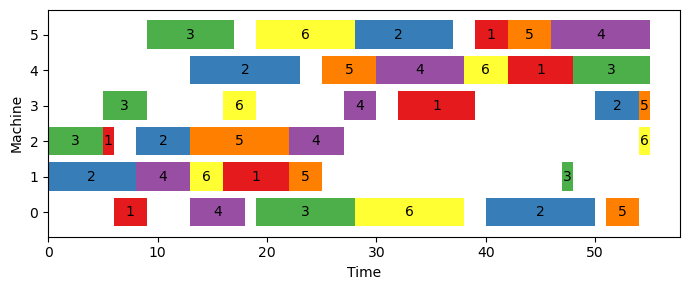

In [115]:
#| code-fold: false
#| label: fig-jssp-dis-sol-ft06
#| fig-cap: Optimal solution of the ft06 instance using the disjunctive formulation

import matplotlib as mpl
import matplotlib.pyplot as plt

def show_schedule(num_jobs, operations, processing_times, opt_time):
    colors = mpl.colormaps["Set1"].colors

    fig, ax = plt.subplots(figsize=[7, 3], dpi=100)

    for idx, job in enumerate(range(num_jobs)):
        machines = operations[job]
        job_start_times = [opt_time[machine][job] 
                            for machine in machines]
        job_processing_times = [processing_times[job][machine] 
                                for machine in operations[job]]
        
        if idx >= len(colors):
            idx = idx % len(colors)
        color = colors[idx]

        bars = ax.barh(machines, 
                width=job_processing_times, 
                left=job_start_times, 
                label=f'Job {job + 1}', 
                color=color)
        
        ax.bar_label(bars, 
                    fmt=f'{job + 1}', 
                    label_type='center')
        
    ax.set_yticks(machines)
    ax.set_xlabel("Time")
    ax.set_ylabel("Machine")
    fig.tight_layout()
    plt.show()
    
show_schedule(num_jobs, operations, processing_times, opt_time)

2. Time-indexed model

The time-indexed formulation, proposed by @kondili_general_1988 and @ku_mixed_2016, involves the use of a binary variable $x_{ijt}$ that takes the value of 1 if job $j$ starts at time $t$ on machine $i$.
The model can be expressed as follows.

\begin{align}
\text{min.} &\quad C_{max} \label{jsp-time-obj}\\
\text{s.t.} &\quad \sum_{t \in H} x_{ijt} = 1, \ \forall j \in \mathcal{J}, i \in \mathcal{M} \label{jsp-time-cons1} \\
&\quad \sum_{t \in H} (t + p_{ij}) \cdot x_{ijt} \leq C_{max}, \ \forall j \in \mathcal{J}, i \in \mathcal{M} \label{jsp-time-cons2} \\
&\quad \sum_{j \in \mathcal{J}} \sum_{t' \in T_{ijt}} x_{ijt'} \leq 1, \ \forall i \in \mathcal{M}, t \in H, T_{ijt} = \{t - p_{ij} + 1, \cdots, t\} \label{jsp-time-cons3} \\
&\quad \sum_{t \in H} (t + p_{o_{h - 1}^j}, j) \cdot x_{o_{h - 1}^j, jt} \leq \sum_{t \in H} t \cdot x_{o_h^j, jt}, \ \forall j \in \mathcal{J}, h = 2, \cdots, m \label{jsp-time-cons4} \\
&\quad x_{ijt} \in \{0, 1\}, \ \forall j \in \mathcal{J}, i \in \mathcal{M}, t \in H \label{jsp-time-cons5}
\end{align}

In this formulation, the first set of constraints, referred to as \eqref{jsp-time-cons1}, state that each job $j$ must start at one specific time within the scheduling horizon $H$, which is determined as the sum of processing times for all jobs - $H = \sum_{i \in \mathcal{I}, j \in \mathcal{J}} p_{ij}$. Constraints \eqref{jsp-time-cons2} are used to calculate the value of $C_{max}$, while constraints \eqref{jsp-time-cons3} ensure that only one job can be processed by a machine at any given time. It's important to note that a job will remain on a machine for its full processing time and cannot be interrupted. Constraints \eqref{jsp-time-cons4} make sure that the order of processing jobs is followed, and constraints \eqref{jsp-time-cons5} define the variable types used in the formulation.

The following code provides a program that uses the time-indexed formulation to solve the `ft06` instance, with the value of $H$ being the sum of all job processing times plus one. 
The two variables, $x_{ijt}$ and $C_{max}$, are created in lines 18 - 27.
The constraints are created in lines 33 - 57.
The optimal solution is retrieved in lines 61 - 71.
It can be seen from the output that the same optimal objective, 55, is obtained using this formulation.

In [145]:
#| code-line-numbers: true

from typing import List, Dict
from ortools.linear_solver import pywraplp
import numpy as np

# read and parse the data
filename = './data/jssp/ft06.txt'
num_jobs, num_machines, \
operations, processing_times = \
    read_jssp_instance(filename)
    
# create solver
solver = pywraplp.Solver.CreateSolver('SCIP')

# create variables
H = 1
for job in processing_times:
    H += sum(processing_times[job].values())
var_x = np.empty((num_machines, num_jobs, H), dtype=object)
for machine in range(num_machines):
    for job in range(num_jobs):
        for t in range(H):
            var_x[machine][job][t] = solver.BoolVar(name=f'x_{machine, job, t}')

infinity = solver.Infinity()
var_makespan = solver.NumVar(0, 
                            infinity, 
                            name='C_max')

# create objective
solver.Minimize(var_makespan)

# create constraints
for machine in range(num_machines):
    for job in range(num_jobs):
        solver.Add(solver.Sum([var_x[machine][job][t] for t in range(H)]) == 1)
        
for machine in range(num_machines):
    for job in range(num_jobs):
        arr = [var_x[machine][job][t] * (t + processing_times[job][machine]) for t in range(H)]
        solver.Add(solver.Sum(arr) <= var_makespan)
        
for machine in range(num_machines):
    for t in range(H):
        arr = [var_x[machine][job][tt]
                    for job in range(num_jobs)
                    for tt in range(t - processing_times[job][machine] + 1, t + 1)]
        solver.Add(solver.Sum(arr) <= 1)

for job in range(num_jobs):
    for oper in range(1, num_machines):
        prev_machine = operations[job][oper - 1]
        curr_machine = operations[job][oper]
        expr_prev = [(t + processing_times[job][prev_machine]) * var_x[prev_machine][job][t] 
                    for t in range(H)]
        expr_curr = [t * var_x[curr_machine][job][t]
                    for t in range(H)]
        solver.Add(solver.Sum(expr_prev) <= solver.Sum(expr_curr))

status = solver.Solve()

if status == solver.OPTIMAL:
    print(f"min. makespan = {solver.Objective().Value():.2f}")
    
    opt_time = []
    for machine in range(num_machines):
        arr = []
        for job in range(num_jobs):
            for t in range(t):
                if int(var_x[machine][job][t].solution_value()) == 1:
                    arr.append(t)
        opt_time.append(arr)

min. makespan = 55.00


The optimal solution can be seen in @fig-jssp-time-sol-ft06. Even though both formulations achieve the same optimal objective value, there are some minor discrepancies between the optimal solutions. For instance, in @fig-jssp-dis-sol-ft06, there is a gap after job 4 completes processing on machine 3, which is not present in @fig-jssp-time-sol-ft06.

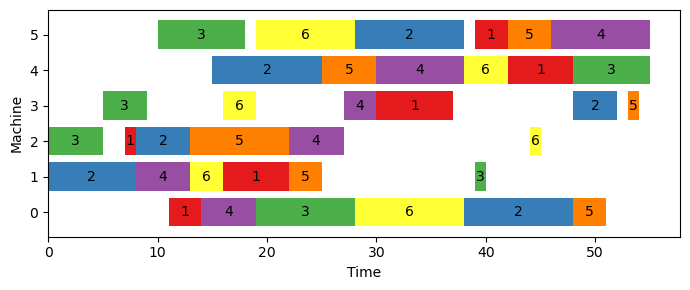

In [146]:
#| label: fig-jssp-time-sol-ft06
#| fig-cap: Optimal solution of the ft06 instance using the time-indexed formulation

show_schedule(num_jobs, operations, processing_times, opt_time)

3. Rank-based model

The rank-based model is due to @wagner_integer_1959 and taken from @ku_mixed_2016.
There are three decision variables in this formulation:

- $x_{ijk}$: a binary variable that equals 1 if job $j$ is scheduled at the $k$-th position on machine $i$
- $h_{ik}$: a numerical variable that represents the start time of job at the $k$-th position of machine $i$.
- $C_{max}$: the makespan to be minimized

The complete model is given below.

\begin{align}
\text{min.} &\quad C_{max} \label{jsp-rank-obj} \\
\text{s.t.} &\quad \sum_{j \in \mathcal{J}} x_{ijk} = 1, \ \forall i \in \mathcal{M}, k = 1, \cdots, n \label{jsp-rank-cons1} \\
&\quad \sum_{k = 1}^n x_{ijk} = 1, \ \forall i \in \mathcal{M}, j \in \mathcal{J} \label{jsp-rank-cons2} \\
&\quad h_{ik} + \sum_{j \in \mathcal{J}} p_{ij} x_{ijk} \leq h_{i,k+1}, \ \forall i \in \mathcal{M}, k = 1, \cdots, n-1 \label{jsp-rank-cons3}\\
&\quad 
\begin{split}
    &\sum_{i \in \mathcal{M}} r_{ijl} h_{ik} + \sum_{i \in \mathcal{M}} r_{ijl}p_{ij} \leq V \cdot (1 - \sum_{i \in \mathcal{M}}r_{ijl}x_{ijk})\  +\  \\ 
    &V \cdot (1 - \sum_{i \in \mathcal{M}}r_{ij,l+1}x_{ijk'}) + \sum_{i \in \mathcal{M}}r_{ij,l+1}h_{ik'},\\ 
    &\forall j \in \mathcal{J}, k, k' = 1, \cdots, n, l = 1, \cdots, m - 1 
\end{split}
\label{jsp-rank-cons4}\\
&\quad h_{in} + \sum_{j \in \mathcal{J}} p_{ij}x_{ijk} \leq C_{max}, \ \forall i \in \mathcal{M} \label{jsp-rank-cons5}\\
&\quad h_{ik} \geq 0, \ \forall i \in \mathcal{M}, k = 1, \cdots, n \label{jsp-rank-cons6} \\
&\quad x_{ijk} \in \{0, 1\}, \ \forall j \in \mathcal{J}, i \in \mathcal{M}, k = 1, \cdots, n \label{jsp-rank-cons7}\\
&\quad C_{max} \geq 0 \label{jsp-rank-cons8}
\end{align}

In this formulation, constraints \eqref{jsp-rank-cons1} make sure that there is only one job assigned to a particular rank $k$ on machine $i$.
Constraints \eqref{jsp-rank-cons2} ensure that any job $j$ is assigned to one and only one rank on a machine $i$.
Constraints \eqref{jsp-rank-cons3} require that a machine can only process at most one job at any point of time.
Constraints \eqref{jsp-rank-cons4} guarantee that the processing order of a job is respected.
Constraints \eqref{jsp-rank-cons5} computes the makespan.
The remaining constraints \eqref{jsp-rank-cons6}, \eqref{jsp-rank-cons7} and \eqref{jsp-rank-cons8} indicate the variable types.

We now solve the same problem instance using this rank-based formulation in Google OR-Tools, for which the complete code is shown below.

In [151]:
#| code-line-numbers: true

from typing import List
from itertools import product
import numpy as np
from ortools.linear_solver import pywraplp

# read and parse the data
filename = './data/jssp/ft06.txt'
num_jobs, num_machines, \
operations, processing_times = \
    read_jssp_instance(filename)
    
# create solver
solver = pywraplp.Solver.CreateSolver('SCIP')

# create variables
var_x = np.empty(shape=(num_machines, num_jobs, num_jobs), dtype=object)
for machine, job, rank in product(range(num_machines), 
                                range(num_jobs), 
                                range(num_jobs)):
    var_x[machine][job][rank] = solver.BoolVar(name=f'x_{machine, job, rank}')
            

infinity = solver.Infinity()
var_h = np.empty(shape=(num_machines, num_jobs), dtype=object)
for machine, rank in product(range(num_machines), range(num_jobs)):
    var_h[machine][rank] = solver.NumVar(0, infinity, name=f'h_{machine, rank}')

var_makespan = solver.NumVar(0, infinity, name=f'makesplan')

# create objective
solver.Minimize(var_makespan)

# create constraints
for machine, rank in product(range(num_machines), range(num_jobs)):
    expr = [var_x[machine][job][rank] for job in range(num_jobs)]
    solver.Add(solver.Sum(expr) == 1)

for machine, job in product(range(num_machines), range(num_jobs)):
    expr = [var_x[machine][job][rank] for rank in range(num_jobs)]
    solver.Add(solver.Sum(expr) == 1)

for machine, rank in product(range(num_machines), range(num_jobs - 1)):
    expr = [var_x[machine][job][rank] * processing_times[job][machine] 
            for job in range(num_jobs)]
    solver.Add(var_h[machine][rank] + solver.Sum(expr) <= var_h[machine][rank + 1])

r = np.zeros((num_machines, num_jobs, num_machines))
for job in range(num_jobs):
    job_operations: List = operations[job]
    for o_idx, o_machine in enumerate(job_operations):
        r[o_machine][job][o_idx] = 1
V = 0
for job in processing_times:
    V += sum(processing_times[job].values())

for job, k, kk, l in product(range(num_jobs), 
                            range(num_jobs), 
                            range(num_jobs), 
                            range(num_machines - 1)):
    expr_1 = [r[machine][job][l] * var_h[machine][k] 
            for machine in range(num_machines)]
    expr_2 = [r[machine][job][l] * processing_times[job][machine]
            for machine in range(num_machines)]
    expr_3 = [r[machine][job][l] * var_x[machine][job][k]
            for machine in range(num_machines)]
    expr_4 = [r[machine][job][l + 1] * var_x[machine][job][kk] 
            for machine in range(num_machines)]
    expr_5 = [r[machine][job][l + 1] * var_h[machine][kk] 
            for machine in range(num_machines)]
    solver.Add(solver.Sum(expr_1) + solver.Sum(expr_2) <= V * (1 - solver.Sum(expr_3)) + V * (1 - solver.Sum(expr_4)) + solver.Sum(expr_5))

for machine in range(num_machines):
    expr = [var_x[machine][job][num_jobs - 1] * processing_times[job][machine] for job in range(num_jobs)]
    solver.Add(var_h[machine][num_jobs - 1] + solver.Sum(expr) <= var_makespan)

status = solver.Solve()

if status == pywraplp.Solver.OPTIMAL:
    print(f"opt_obj = {solver.Objective().Value():.4f}")
    opt_time = []
    for machine in range(num_machines):
        arr = []
        for job in range(num_jobs):
            for rank in range(num_jobs):
                if int(var_x[machine][job][rank].solution_value()) == 1:
                    arr.append(var_h[machine][rank].solution_value())
        opt_time.append(arr)


opt_obj = 55.0000


@fig-jssp-rank-sol-ft06 displays the optimal solution obtained by utilizing the rank-based model. Upon careful examination, it is slightly distinct from the optimal solutions produced by the disjunctive model and the time-indexed model. Nevertheless, all three models achieve the same objective value of 55.

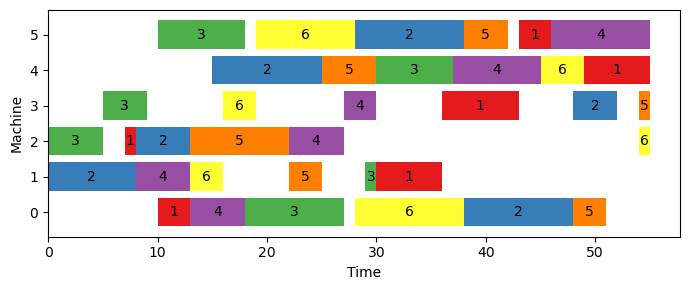

In [152]:
#| label: fig-jssp-rank-sol-ft06
#| fig-cap: Optional solution found by the rank-based model for instance ft06

show_schedule(num_jobs, operations, processing_times, opt_time)

While this book does not aim to compare the performance of the three modeling approaches, @tbl-jssp-data presents the computational times required by each formulation to discover the optimal solutions. The table indicates that the disjunctive model is the most efficient of the three, followed by the time-indexed model, while the rank-based model requires the longest time to converge. It should be noted that making a conclusion about the performance of these models based on one experimental run on a single instance is insufficient.

In [158]:
# | echo: false
# | label: tbl-jssp-data
# | tbl-cap: Computational time comparison of the three formulations

from IPython.display import Markdown
from tabulate import tabulate

row_names = ["ft06"]
col_names = ["Instance", "Disjunctive Model", "Time-indexed Model", "Rank-based Model"]

jsp_table_data = []
for idx, name in enumerate(row_names):
    if idx >= 3:
        break
    row_data = []
    # add row name
    row_data.append(name)
    
    # add consumption per activitiy/resource
    row_data.append('1.7s')
    row_data.append('1m34.9s')
    row_data.append('11m38.2s')
    
    jsp_table_data.append(row_data)

Markdown(tabulate(jsp_table_data, headers=col_names))

Instance    Disjunctive Model    Time-indexed Model    Rank-based Model
----------  -------------------  --------------------  ------------------
ft06        1.7s                 1m34.9s               11m38.2s

### Capacitated Vehicle Routing Problem

The Capacitated Vehicle Routing Problem (CVRP) is a classical combinatorial optimization problem that involves finding the optimal set of routes for a fleet of vehicles to deliver goods or services to a set of customers.
In the CVRP, a set of customers is given, each with a known demand and location. A fleet of vehicles, each with a limited capacity, is available to serve these customers.
The problem is to find a set of routes visited by the vehicles such that each customer is visited once and only once and the total traveling distance is minimized.

We use the notation provided in @toth_vehicle_2014 to facilitate the presentation of different CVRP models. The depot, denoted as 0, serves as the starting point for transporting goods to customers in $\mathcal{N} = {1, 2, \cdots, n}$ using a homogeneous fleet $\mathcal{K} = {1, 2, \cdots, |\mathcal{K}|}$. 
Each customer in $\mathcal{N}$ has a demand of $q_i \geq 0$, and each vehicle has a positive capacity of $Q > 0$. 
The cost of transportation, denoted by $c_{ij}$, is incurred when a vehicle travels between $i$ and $j$. 
A vehicle's route begins at the depot, visits some or all the customers in $\mathcal{N}$, and then returns to the depot. 
The objective is to determine the optimal set of routes for the fleet to minimize the total cost of transportation.

The CVRP could be defined on a directed graph $\mathcal{G} = (\mathcal{V}, \mathcal{A})$, where $\mathcal{V} = \{0\} \cup \{1, 2, \cdots, n\} = \{0, 1, \cdots, n\}$, and $\mathcal{A} = \{(i, j) | i, j \in \mathcal{V}, i \neq j\}$.
Let $S$ be a subset of $\mathcal{V}$, that is, $S \subseteq \mathcal{V}$.
The in-arcs and out-arcs of $S$ are defined as follows:

- $\delta^-(S) = \{(i, j) \in \mathcal{A} | i \notin S, j \in S \}$
- $\delta^+(S) = \{(i, j) \in \mathcal{A} | i \in S, j \notin S \}$

In addition, we use $\mathcal{A}(S) = \{(i, j) \in \mathcal{A} | i \in S, j \in S \}$ to indicate all the arcs that connect nodes within $S$.

#### CVRP Instances

We use the instances taken from @cvrplib to illustrate the modeling and solving process with Google OR-Tools.
@cvrplib contains many benchmarking instances for CVRP and we use the python package `vrplib` to load the instance `P-n16-k8.vrp` and its optimal solution `P-n16-k8.sol`.

In [56]:
# install vrplib with command: pip install vrplib
import vrplib

# Read VRPLIB formatted instances (default)
instance = vrplib.read_instance("./data/cvrp/P-n16-k8.vrp")
solution = vrplib.read_solution("./data/cvrp/P-n16-k8.sol")

Let's first create a function to visualize vehicle routes, as given below.

In [5]:
import networkx as nx
import numpy as np
import matplotlib as mpl

def show_vehicle_routes(locations, edges):
    """draw vehicles routings
    adapted from https://stackoverflow.com/a/50682819
    
    examples:
    locations = {
        0: (5, 5),
        1: (4, 9),
        2: (6, 4),
        3: (2, 6),
    }

    edges = [
        (0, 1, {'vehicle': '0'}),
        (1, 2, {'vehicle': '0'}),
        (2, 0, {'vehicle': '0'}),
        (0, 3, {'vehicle': '1'}),
        (3, 0, {'vehicle': '1'}),
    ]

    Args:
        locations (dict): location id -> (lat, lon)
        edges (list): list of edges
    """
    G = nx.DiGraph()
    G.add_edges_from(edges)
    plt.figure(figsize=(15,10))
    
    vehicles = set([e[2]['vehicle'] for e in edges])
    num_vehicles = len(vehicles)
    
    colors = mpl.colormaps["Set1"].colors
    for v in range(num_vehicles):
        temp = [e for e in edges if e[2]['vehicle'] == str(v)]
        
        color_idx = v 
        if color_idx >= len(colors):
            color_idx = color_idx % len(colors)
        color = np.array([colors[color_idx]])
        
        nx.draw_networkx_nodes(G, 
                                locations, 
                                nodelist=[x[0] for x in temp], 
                                node_color=color)
        nx.draw_networkx_edges(G,
                                locations, 
                                edgelist=temp,
                                width=2, 
                                edge_color=color, 
                                style='dashed')

    #let's color the node 0 in black
    nx.draw_networkx_nodes(G, locations, 
                            nodelist=[0], 
                            node_color='k')

    # labels
    nx.draw_networkx_labels(G, locations, 
                            font_color='w', 
                            font_size=12, 
                            font_family='sans-serif')

    #print out the graph
    plt.axis('off')
    plt.show()

@fig-cvrp-p-n16-k6-sol shows the optimal vehicle routes for the instance P-n16-k8.vrp.

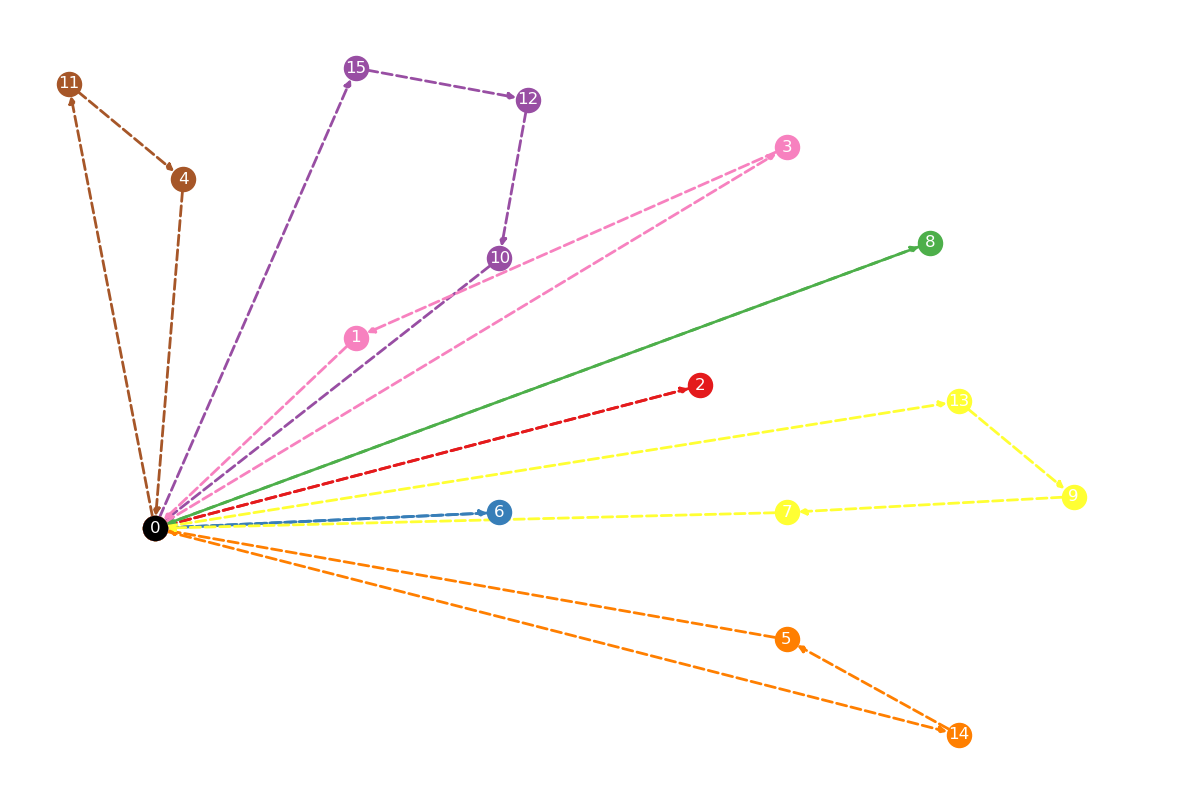

In [72]:
#| code-fold: true
#| label: fig-cvrp-p-n16-k6-sol
#| fig-cap: Optimal routes for instance P-n16-k8.vrp

# visualize the optimal solution
node_coords = instance['node_coord']
locations = {}
for idx, coord in enumerate(node_coords):
    locations[idx] = (coord[0], coord[1])

routes = solution['routes']
vehicle_idx = 0
edges = []
for route in routes:
    r_temp = route.copy()
    r_temp.insert(0, 0)
    r_temp.insert(len(r_temp), 0)
    for i in range(len(r_temp) - 1):
        edges.append((r_temp[i], r_temp[i + 1], {'vehicle': str(vehicle_idx)}))
    
    vehicle_idx += 1

show_vehicle_routes(locations, edges)

#### Two-index Formulation - 1

This formulation was proposed by @laporte_exact_1986 and we present the formulation given in @toth_vehicle_2014.
In this formulation, we define the variable $x_{ij}$ that equals 1 if the arc $(i, j)$ is traversed by a vehicle.
The complete model is given below.

\begin{align}
    \text{min.} &\quad \sum_{(i, j) \in \mathcal{A}} c_{ij} x_{ij} \label{cvrp-two-index-obj} \\
    \text{s.t.} &\quad \sum_{j \in \delta^+(i)}x_{ij} = 1, \ \forall i \in \mathcal{N} \label
    {cvrp-two-index-cons1}\\
    &\quad \sum_{i \in \delta^-(j)} x_{ij} = 1, \ \forall j \in \mathcal{N} \label{cvrp-two-index-cons2} \\
    &\quad \sum_{j \in \delta^+(0)} x_{oj} = |\mathcal{K}| \label{cvrp-two-index-cons3} \\
    &\quad \sum_{(i, j) \in \delta^+(S)} x_{ij} \geq r(S), \ \forall S \subseteq \mathcal{N}, S \neq \emptyset \label{cvrp-two-index-cons4} \\
    &\quad x_{ij} \in \{0, 1\}, \ \forall (i, j) \in \mathcal{A} \label{cvrp-two-index-cons5}
\end{align}

The objective function represented by equation \eqref{cvrp-two-index-obj} is to minimize the overall transportation costs. The constraints expressed in equations \eqref{cvrp-two-index-cons1} and \eqref{cvrp-two-index-cons2} work together to guarantee that each customer is visited only once, with one incoming and outgoing arc. Constraints \eqref{cvrp-two-index-cons3} ensure that all available vehicles are utilized to serve the customers. Constraints \eqref{cvrp-two-index-cons4} prevent the formation of sub-tours. Finally, the variable types are defined by the last set of constraints, which are presented in equation \eqref{cvrp-two-index-cons5}.

To solve the aforementioned instance, we'll first prepare the data for our following implementation use.
Let's first define two classes, `Node` and `Vehicle`, to represent a node in the network and the vechiles, respectively.

In [6]:
class Node:
    """a node is either a depot (0) or a customer
    """
    
    def __init__(self, id, x_coord, y_coord, demand):
        self._id = id
        self._x_coord = x_coord
        self._y_coord = y_coord
        self._demand = demand
        
    @property
    def id(self): return self._id
    
    @property
    def x_coord(self): return self._x_coord
    
    @property
    def y_coord(self): return self._y_coord
    
    @property
    def demand(self): return self._demand
    
    def __str__(self):
        return f"id: {self._id}, x_coord: {self._x_coord}, y_coord: {self._y_coord}, demand: {self._demand}"

In [7]:
class Vehicle:
    """a vehicle
    """
    
    def __init__(self, id, capacity):
        self._id = id
        self._capacity = capacity
        
    @property
    def id(self): return self._id
    
    @property
    def capacity(self): return self._capacity
    
    def __str__(self):
        return f"id: {self._id}, capacity: {self._capacity}"

Now let's define a class `CvrpDataCenter` to hold all the information we need later.
It also has a helper function to read and parse an CVRP instance.

In [2]:
from typing import List
import vrplib
import re
from itertools import combinations

class CvrpDataCenter:
    """this class manages all the data for a CVRP instance
    """
    
    def __init__(self):
        self._nodes: List = None
        self._vehicles: List = None
        self._distance: List[List] = None

    def read_cvrp_instance(self, instance_file):
        """read a given cvrp instance

        Args:
            instance_file (str): instance file
        """
        instance = vrplib.read_instance(instance_file)

        # gather nodes
        nodes = []
        idx = 0
        for node, demand in zip(instance['node_coord'], 
                                instance['demand']):
            node = Node(id=idx, 
                        x_coord=node[0], 
                        y_coord=node[1], 
                        demand=demand)
            idx += 1
            nodes.append(node)
            
        # gather vehicles
        comment = instance['comment']
        num_vehicles = int(re.search(r'\d', comment).group())
        vehicles = []
        for v in range(num_vehicles):
            vehicle = Vehicle(v, int(instance['capacity']))
            vehicles.append(vehicle)
        
        # gather distance matrix
        distance = instance['edge_weight']
        
        self._nodes = nodes
        self._vehicles = vehicles
        self._distance = distance
    
    @property
    def nodes(self): return self._nodes
    
    @property
    def vehicles(self): return self._vehicles
    
    @property
    def num_nodes(self): return len(self._nodes)
    
    @property
    def num_vehicles(self): return len(self._vehicles)
    
    @property
    def vehicle_capacity(self): 
        return self._vehicles[0].capacity

    def distance(self, i, j, integer=False):
        return round(self._distance[i][j]) \
            if integer else self._distance[i][j]
    
    def get_all_combinations(self, numbers):
        combs = []
        for i in range(1, len(numbers) + 1):
            combs.extend(list(combinations(numbers, i)))
        return combs

To implement this formulation using Google OR-Tools, we first create a `CvrpDataCenter` object and read in the instance `P-n16-k8.vrp`.
Then we create a `solver` object with solver option `SCIP` to solve mixed integer programming problems.

In [210]:
from ortools.linear_solver import pywraplp
import numpy as np
from itertools import product
import math

# prepare instance
cvrp_data_center = CvrpDataCenter()
cvrp_data_center.read_cvrp_instance("./data/cvrp/P-n16-k8.vrp")

# instantiate solver
solver = pywraplp.Solver.CreateSolver('SCIP')

Now let's create the decision variable $x_{ij}$.
Note that we don't need to create variables when $i = j$ since there is no arc pointing to itself in the graph $\mathcal{G}$ we defined earlier.

In [204]:
# create decision variables
num_nodes = cvrp_data_center.num_nodes
num_vehicles = cvrp_data_center.num_vehicles
var_x = np.empty((num_nodes, num_nodes), dtype=object)
for i, j in product(range(num_nodes), range(num_nodes)):
    if i == j: continue
    var_x[i][j] = solver.BoolVar(name="x_{i, j}")

Then we create the objective function.

In [205]:
# define objective function
obj_expr = [
    cvrp_data_center.distance(i, j, integer=True) * var_x[i][j]
    for i, j in product(range(num_nodes), range(num_nodes))
    if i != j
]
solver.Minimize(solver.Sum(obj_expr))

And we create the constraints \eqref{cvrp-two-index-cons1} and \eqref{cvrp-two-index-cons2}.

In [206]:
# create incoming and outgoing arc constraints
for i in range(1, num_nodes):
    out_arcs = [var_x[i][j] for j in range(num_nodes) if j != i]
    in_arcs = [var_x[j][i] for j in range(num_nodes) if j != i]
    solver.Add(solver.Sum(out_arcs) == 1)
    solver.Add(solver.Sum(in_arcs) == 1)

Constraints \eqref{cvrp-two-index-cons3} are created as follows.

In [ ]:
# create fleet size constraint
expr = [var_x[0][i] for i in range(1, num_nodes)]
solver.Add(solver.Sum(expr) == num_vehicles)

\newcommand{\ceil}[1]{\lceil {#1} \rceil}

To create the subtour elimination constraints \eqref{cvrp-two-index-cons4}, we first need to enumerate all the non-empty subset of $\mathcal{N}$, for which we define a helper function named `get_all_combinations()` in the `CvrpDataCenter` class.
In the code snippet below, we define a separate constraint for every nonempty customer set $S$, and the right-hand side $r(S)$ is defined as $\ceil{q(S) / Q}$.

In [ ]:
# create subtour elimination constraint
nodes = cvrp_data_center.nodes
vehicle_capacity = cvrp_data_center.vehicle_capacity
customer_ids = [node.id for node in nodes if node.id > 0]
node_ids = [node.id for node in nodes]
nonempty_customer_sets = cvrp_data_center.get_all_combinations(customer_ids)
for customer_set in nonempty_customer_sets:
    others = set(node_ids).difference(customer_set)
    expr = [var_x[i][j]
            for i in customer_set
            for j in others]
    total_demand = sum([node.demand 
                        for node in nodes 
                        if node.id in set(customer_set)])
    rhs = math.ceil(total_demand / vehicle_capacity)
    solver.Add(solver.Sum(expr) >= rhs)

Putting it all together, we have the complete program below.
It can be seen from the output that the optimal solution is 450 and there are 8 routes in the identified solution.

In [7]:
from ortools.linear_solver import pywraplp
import numpy as np
from itertools import product
import math

# prepare instance
cvrp_data_center = CvrpDataCenter()
cvrp_data_center.read_cvrp_instance("./data/cvrp/P-n16-k8.vrp")

# instantiate solver
solver = pywraplp.Solver.CreateSolver('SCIP')

# create decision variables
num_nodes = cvrp_data_center.num_nodes
num_vehicles = cvrp_data_center.num_vehicles
var_x = np.empty((num_nodes, num_nodes), dtype=object)
for i, j in product(range(num_nodes), range(num_nodes)):
    if i == j: continue
    var_x[i][j] = solver.BoolVar(name="x_{i, j}")

# define objective function
obj_expr = [
    cvrp_data_center.distance(i, j, integer=True) * var_x[i][j]
    for i, j in product(range(num_nodes), range(num_nodes))
    if i != j
]
solver.Minimize(solver.Sum(obj_expr))

# create incoming and outgoing arc constraints
for i in range(1, num_nodes):
    out_arcs = [var_x[i][j] for j in range(num_nodes) if j != i]
    in_arcs = [var_x[j][i] for j in range(num_nodes) if j != i]
    solver.Add(solver.Sum(out_arcs) == 1)
    solver.Add(solver.Sum(in_arcs) == 1)

# create fleet size constraint
expr = [var_x[0][i] for i in range(1, num_nodes)]
solver.Add(solver.Sum(expr) == num_vehicles)

# create subtour elimination constraint
nodes = cvrp_data_center.nodes
vehicle_capacity = cvrp_data_center.vehicle_capacity
customer_ids = [node.id for node in nodes if node.id > 0]
node_ids = [node.id for node in nodes]
nonempty_customer_sets = cvrp_data_center.get_all_combinations(customer_ids)
for customer_set in nonempty_customer_sets:
    others = set(node_ids).difference(customer_set)
    expr = [var_x[i][j]
            for i in customer_set
            for j in others]
    total_demand = sum([node.demand 
                        for node in nodes 
                        if node.id in set(customer_set)])
    rhs = math.ceil(total_demand / vehicle_capacity)
    solver.Add(solver.Sum(expr) >= rhs)
    
status = solver.Solve()
if not status:
    opt_obj = solver.Objective().Value()
    print(f'optimal value: {opt_obj}')
    
    opt_x = np.zeros((num_nodes, num_nodes))
    for i, j in product(range(num_nodes), range(num_nodes)):
        if i == j: continue
        opt_x[i][j] = int(var_x[i][j].solution_value())

    routes = []
    for i in range(1, num_nodes):
        if opt_x[0][i] == 0: continue
        # new route found
        route = []
        
        route_length = 0
        # add the first arc
        arc_start = 0
        arc_end = i
        route.append((arc_start, arc_end))
        route_length += cvrp_data_center.distance(arc_start, 
                                                arc_end, 
                                                integer=True)
        
        # add remaining arcs on the route
        arc_start = arc_end
        while True:
            for j in range(num_nodes):
                if opt_x[arc_start][j] == 1:
                    arc_end = j
                    break
            route.append((arc_start, arc_end))
            route_length += cvrp_data_center.distance(arc_start, 
                                                    arc_end, 
                                                    integer=True)
            if arc_end == 0: break
            arc_start = arc_end

        routes.append(route)
        print(f'route: {route}, length: {route_length}')

optimal value: 450.0
route: [(0, 1), (1, 0)], length: 28
route: [(0, 2), (2, 0)], length: 42
route: [(0, 4), (4, 11), (11, 0)], length: 57
route: [(0, 5), (5, 9), (9, 3), (3, 0)], length: 93
route: [(0, 6), (6, 0)], length: 24
route: [(0, 10), (10, 12), (12, 15), (15, 0)], length: 67
route: [(0, 13), (13, 8), (8, 0)], length: 71
route: [(0, 14), (14, 7), (7, 0)], length: 68


@fig-cvrp-two-index-sol shows the routes found by the two-index formulation.
Note that the routes are different from the ones in @fig-cvrp-p-n16-k6-sol but they have the same objective value.

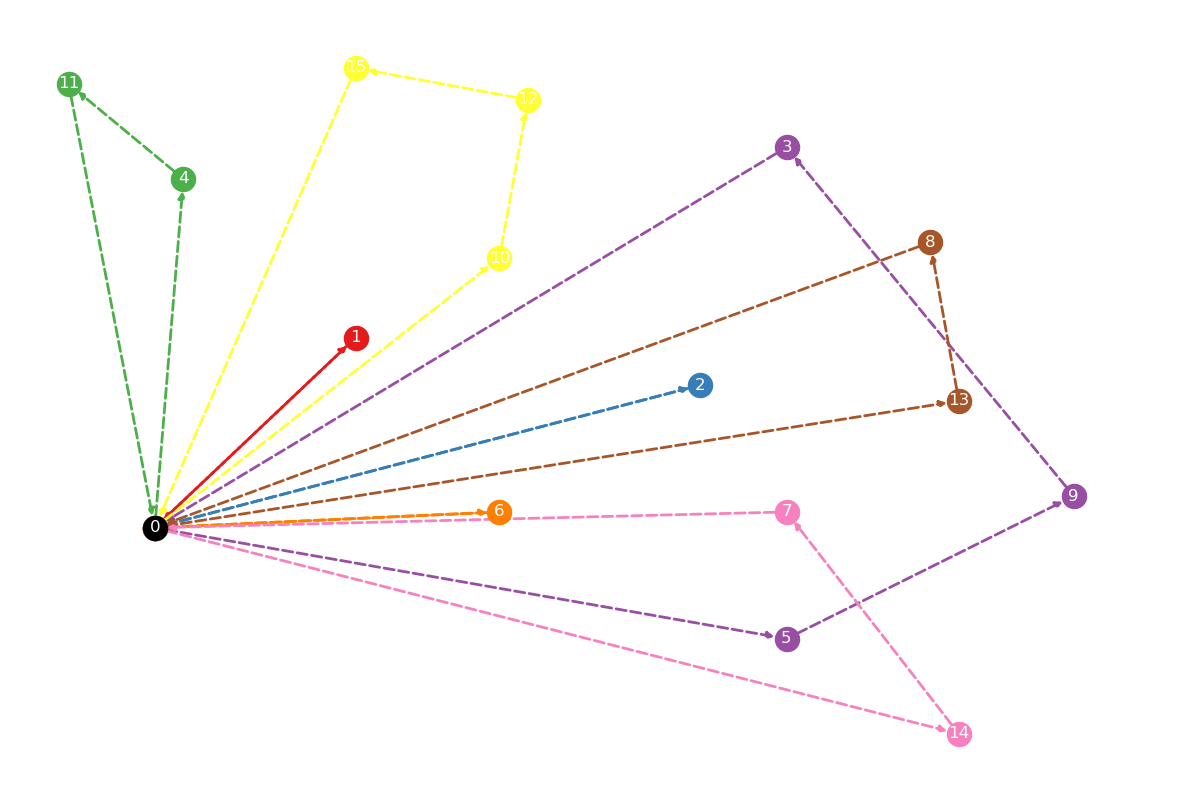

In [202]:
#| code-fold: true
#| label: fig-cvrp-two-index-sol
#| fig-cap: Optimal routes found by the two-index formulation
locations = {
    node.id: (node.x_coord, node.y_coord)
    for node in nodes
}

edges = []
vehicle_idx = 0
for route in routes:
    for arc in route:
        edges.append((arc[0], arc[1], {'vehicle': str(vehicle_idx)}))
    vehicle_idx += 1
edges

show_vehicle_routes(locations, edges)

To facilitate the model comparison in following steps, we'll wrap the above program into a dedicated class `CvrpTwoIndexModel1`.

In [19]:
from ortools.linear_solver import pywraplp
from itertools import product
import numpy as np
import math

class CvrpTwoIndexModel1:
    """solve the cvrp model using the two index formulation
    """

    def __init__(self, cvrp_data_center: CvrpDataCenter):
        self._data_center: CvrpDataCenter = cvrp_data_center
        self._solver = pywraplp.Solver.CreateSolver('SCIP')
        self._var_x = None
        
        self._opt_obj = None
        self._opt_x = None
        self._opt_routes = None
    
    def read_instance(self, instance_file):
        self._data_center.read_cvrp_instance(instance_file)

    def build_model(self):
        self._create_variables()
        self._create_objective()
        self._create_constr_flow()
        self._create_constr_fleet()
        self._create_constr_subtour()
        
    def optimize(self):
        status = self._solver.Solve()
        if not status:
            self._retrieve_opt_solution()
            self._retrieve_opt_routes()
    
    def _create_variables(self):
        num_nodes = self._data_center.num_nodes
        self._var_x = np.empty((num_nodes, num_nodes), dtype=object)
        for i, j in product(range(num_nodes), range(num_nodes)):
            if i == j: continue
            self._var_x[i][j] = self._solver.BoolVar(name="x_{i, j}")

    def _create_objective(self):
        num_nodes = self._data_center.num_nodes
        obj_expr = [
            self._data_center.distance(i, j, integer=True) * 
                self._var_x[i][j]
                for i, j in product(range(num_nodes), range(num_nodes))
                if i != j
        ]
        self._solver.Minimize(self._solver.Sum(obj_expr))
            
    def _create_constr_flow(self):
        # create incoming and outgoing arc constraints
        num_nodes = self._data_center.num_nodes
        for i in range(1, num_nodes):
            out_arcs = [self._var_x[i][j] for j in range(num_nodes) if j != i]
            in_arcs = [self._var_x[j][i] for j in range(num_nodes) if j != i]
            self._solver.Add(self._solver.Sum(out_arcs) == 1)
            self._solver.Add(self._solver.Sum(in_arcs) == 1)
            
    def _create_constr_fleet(self):
        # create fleet size constraint
        num_nodes = self._data_center.num_nodes
        num_vehicles = self._data_center.num_vehicles
        expr = [self._var_x[0][i] for i in range(1, num_nodes)]
        self._solver.Add(self._solver.Sum(expr) == num_vehicles)
    
    def _create_constr_subtour(self):
        # create subtour elimination constraint
        nodes = self._data_center.nodes
        vehicle_capacity = self._data_center.vehicle_capacity
        customer_ids = [node.id for node in nodes if node.id > 0]
        node_ids = [node.id for node in nodes]
        nonempty_customer_sets = self._data_center.get_all_combinations(customer_ids)
        for customer_set in nonempty_customer_sets:
            others = set(node_ids).difference(customer_set)
            expr = [self._var_x[i][j]
                    for i in customer_set
                    for j in others]
            total_demand = sum([node.demand 
                                for node in nodes 
                                if node.id in set(customer_set)])
            rhs = math.ceil(total_demand / vehicle_capacity)
            self._solver.Add(self._solver.Sum(expr) >= rhs)
        print(f"No. subtour elimination constraints: {len(nonempty_customer_sets)}")
    
    def show_model_summary(self):
        print(f"No. of variables: {self._solver.NumVariables()}")
        print(f"No. of constraints: {self._solver.NumConstraints()}")
    
    def _retrieve_opt_solution(self):
        self._opt_obj = self._solver.Objective().Value()
        print(f'optimal value: {self._opt_obj}')
        
        num_nodes = self._data_center.num_nodes
        self._opt_x = np.zeros((num_nodes, num_nodes))
        for i, j in product(range(num_nodes), range(num_nodes)):
            if i == j: continue
            self._opt_x[i][j] = int(self._var_x[i][j].solution_value())

    def _retrieve_opt_routes(self):
        num_nodes = self._data_center.num_nodes
        self._routes = []
        for i in range(1, num_nodes):
            if self._opt_x[0][i] == 0: continue
            # new route found
            route = []
            
            route_length = 0
            # add the first arc
            arc_start = 0
            arc_end = i
            route.append((arc_start, arc_end))
            route_length += self._data_center\
                    .distance(arc_start, 
                            arc_end,
                            integer=True)
            
            # add remaining arcs on the route
            arc_start = arc_end
            while True:
                for j in range(num_nodes):
                    if self._opt_x[arc_start][j] == 1:
                        arc_end = j
                        break
                route.append((arc_start, arc_end))
                route_length += self._data_center\
                    .distance(arc_start,
                            arc_end,
                            integer=True)
                if arc_end == 0: break
                arc_start = arc_end

            self._routes.append(route)
            print(f'route: {route}, length: {route_length}')

The code below validates that the same optimal solution is obtained using this object-oriented approach.

In [20]:
cvrp_two_index_model_1 = CvrpTwoIndexModel1(CvrpDataCenter())
cvrp_two_index_model_1.read_instance("./data/cvrp/P-n16-k8.vrp")
cvrp_two_index_model_1.build_model()
cvrp_two_index_model_1.show_model_summary()
cvrp_two_index_model_1.optimize()

No. subtour elimination constraints: 32767
No. of variables: 240
No. of constraints: 32798
optimal value: 450.0
route: [(0, 1), (1, 0)], length: 28
route: [(0, 2), (2, 0)], length: 42
route: [(0, 4), (4, 11), (11, 0)], length: 57
route: [(0, 5), (5, 9), (9, 3), (3, 0)], length: 93
route: [(0, 6), (6, 0)], length: 24
route: [(0, 10), (10, 12), (12, 15), (15, 0)], length: 67
route: [(0, 13), (13, 8), (8, 0)], length: 71
route: [(0, 14), (14, 7), (7, 0)], length: 68


It can be seen from the model output that there are a total of 32798 constraints, out of which 32767 are subtour elimination constraints, even for such a small instance with only 15 customers.
In the next section, we will present another two index formulation to handle this exponential number of constraints.

#### Two-index Formulation - 2

#### Three-index Formulation

#### Commodity-flow Formulation